In [1]:
import json
import numpy as np
import glob
import os
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dredFISH.Utils.__init__plots import *
from dredFISH.Utils import basicu 
from dredFISH.Utils import designu
from dredFISH.Utils.miscu import order_by_hc

# inside current dir
import importlib
from data_loaders.data_files import DATABASE as db
from data_loaders.data_loader_scrna import load_Allen_data
from models.model_v3p0_basic import CellTypeNet

In [2]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
torch.manual_seed(0)

# 1. load data

In [3]:
%%time
# load data: train, test, and constraints
trn_dataloader = load_Allen_data(
    datasetkey='smrt_trn', 
    keyX='counts', keyY='l3_code', keyYcat='l3_cat', 
    batch_size=64,
    database=db,
)
tst_dataloader = load_Allen_data(
    datasetkey='smrt_tst', 
    keyX='counts', keyY='l3_code', keyYcat='l3_cat', 
    batch_size=5000,
    database=db,
)
gsubidx      = torch.load(db['smrt_sub140_geneidx'])
cnstrnts_idx = torch.load(db['smrt_pshopcnst_geneidx'])
cnstrnts     = torch.load(db['smrt_pshopcnst'])

n_gns = len(cnstrnts) # trn_dataloader.dataset.X.shape[1] # number of genes
n_cat = len(trn_dataloader.dataset.Ycat) # number of clusters

# load 1 batch
ftrs_batch, clsts_batch = next(iter(tst_dataloader))

CPU times: user 60 s, sys: 9.6 s, total: 1min 9s
Wall time: 19.2 s


In [4]:
# cluster annotation
clst_annots = tst_dataloader.dataset.Ycat[:]
type_orders = clst_annots[np.unique(clsts_batch).astype(int)]
type_orders

array(['Astro', 'CA1-ProS', 'CA2-IG-FC', 'CA3', 'CR', 'CT SUB', 'Car3',
       'DG', 'Endo', 'L2 IT ENTl', 'L2 IT ENTm', 'L2/3 IT CTX',
       'L2/3 IT ENTl', 'L2/3 IT PPP', 'L2/3 IT RHP', 'L3 IT ENT',
       'L4 RSP-ACA', 'L4/5 IT CTX', 'L5 IT CTX', 'L5 PPP', 'L5 PT CTX',
       'L5/6 IT TPE-ENT', 'L5/6 NP CTX', 'L6 CT CTX', 'L6 IT CTX',
       'L6 IT ENTl', 'L6b CTX', 'L6b/CT ENT', 'Lamp5', 'Meis2',
       'Micro-PVM', 'NP PPP', 'NP SUB', 'Oligo', 'Pvalb', 'SMC-Peri',
       'SUB-ProS', 'Sncg', 'Sst', 'Sst Chodl', 'VLMC', 'Vip'],
      dtype='<U15')

# 2. load model

In [5]:
s0 = 1e5
min_sgnl = 1/2*1e5 #1e4
max_sgnl = 1e6 # 2e5 #1e6 # 2*1e5   #1e6
lmd1 = 2
lmd3 = 0
mxpr = 90000

libsize_norm = True
drprt = 0

# studybatch = f'types_v28_Sep15_v6_scale{s0:.1e}_min{min_sgnl:.1e}_max{max_sgnl:.1e}'
studybatch = 'v3p0_basic_2023Jan20'
studybatch

'v3p0_basic_2023Jan20'

In [6]:
rootdat_dir = '/greendata/GeneralStorage/fangming/projects/dredfish/res_nn/' 
samebatch = glob.glob(f'{studybatch}*', root_dir=rootdat_dir)
samebatch

['v3p0_basic_2023Jan20_scale1.0e+05_min5.0e+04_max1.0e+06_nbit24_drprt0.0e+00_lmds_0.0e+00_2.0e+00_1.0e+00_0.0e+00']

In [7]:
# nbits = [24] #[12, 18, 24]# [12, 18, 24] #[3,6,12,24] #,48,72,96]

nbit = 24
lmd0 = 0
lmd1 = 2
lmd2 = 1
lmd3 = 0
n_rcn_layers = 0
lr = 0.01

mean_acc_all = []
n_acc_all = []

n_bits_acc = []

encx_all = []
dcdx_all = []
prjx_all = []
embx_all = []
clsts_all = []

dat_dir = os.path.join(rootdat_dir, samebatch[0])

# prep the model
f = glob.glob(os.path.join(dat_dir, 'model*'))[0]
model= CellTypeNet(n_gns=     n_gns,                      
                   n_cat=     n_cat,                      
                   gsubidx=           gsubidx,
                   cnstrnts_idx= cnstrnts_idx,
                   cnstrnts=     cnstrnts,
                   n_rcn_layers=n_rcn_layers,
                   n_bit=     nbit,
                   lmd0=      lmd0,
                   lmd1=      lmd1,
                   lmd2=      lmd2,
                   lmd3=      lmd3,
                   drprt=     drprt,
                   mxpr=      mxpr,
                   scale=     s0,
                   min_sgnl=  min_sgnl,
                   max_sgnl=  max_sgnl,
                   noise=     None
                  )
model.load_state_dict(torch.load(f, map_location=device))

# evaluate
model.eval()
with torch.no_grad():
    # validation dataset
    ftrs, clsts, ftrs_gsub = model.proc_batch(ftrs_batch, clsts_batch, device, libsize_norm=libsize_norm)

    # categorical
    plgt_fine, ftrs_rcn, emb, bit_cnst = model.forward(ftrs, rnd=True)
    prds_fine = plgt_fine.max(1)[1]
    fine_acc_eval = (prds_fine == clsts).float().mean()

    # break down
    tmp = pd.DataFrame()
    tmp[0] = (prds_fine == clsts).numpy()
    tmp[1] = clsts.numpy()
    mean_acc = tmp.groupby(1).mean().values.reshape(-1,)
    n_acc = tmp.groupby(1).size().values.reshape(-1,)

    # enc mat
    encx = model.get_encmat(rnd=True).detach()
    # enc mat
    dcdx = model.dcd.weight.detach() # get_encmat(rnd=True).detach()

    # get embedding 
    prjx = model.get_prj(ftrs, rnd=False)
    # get normed
    embx, bit_cnst = model.get_emb(ftrs, rnd=False)

    print(f"acc: {fine_acc_eval}")

    encx_all.append(encx)
    dcdx_all.append(dcdx)
    prjx_all.append(prjx)
    embx_all.append(embx)
    clsts_all.append(clsts)
    n_bits_acc.append(fine_acc_eval)

    mean_acc_all.append(mean_acc)
    n_acc_all.append(n_acc)

    # break

acc: 0.9685999751091003


In [8]:
scaleback = np.power(10, model.nrm.logscale).log10() #.exp()
scaleback.item()

5.0

# 3. Check results

## 3.1 Overall performance

In [9]:
nbits = [nbit]

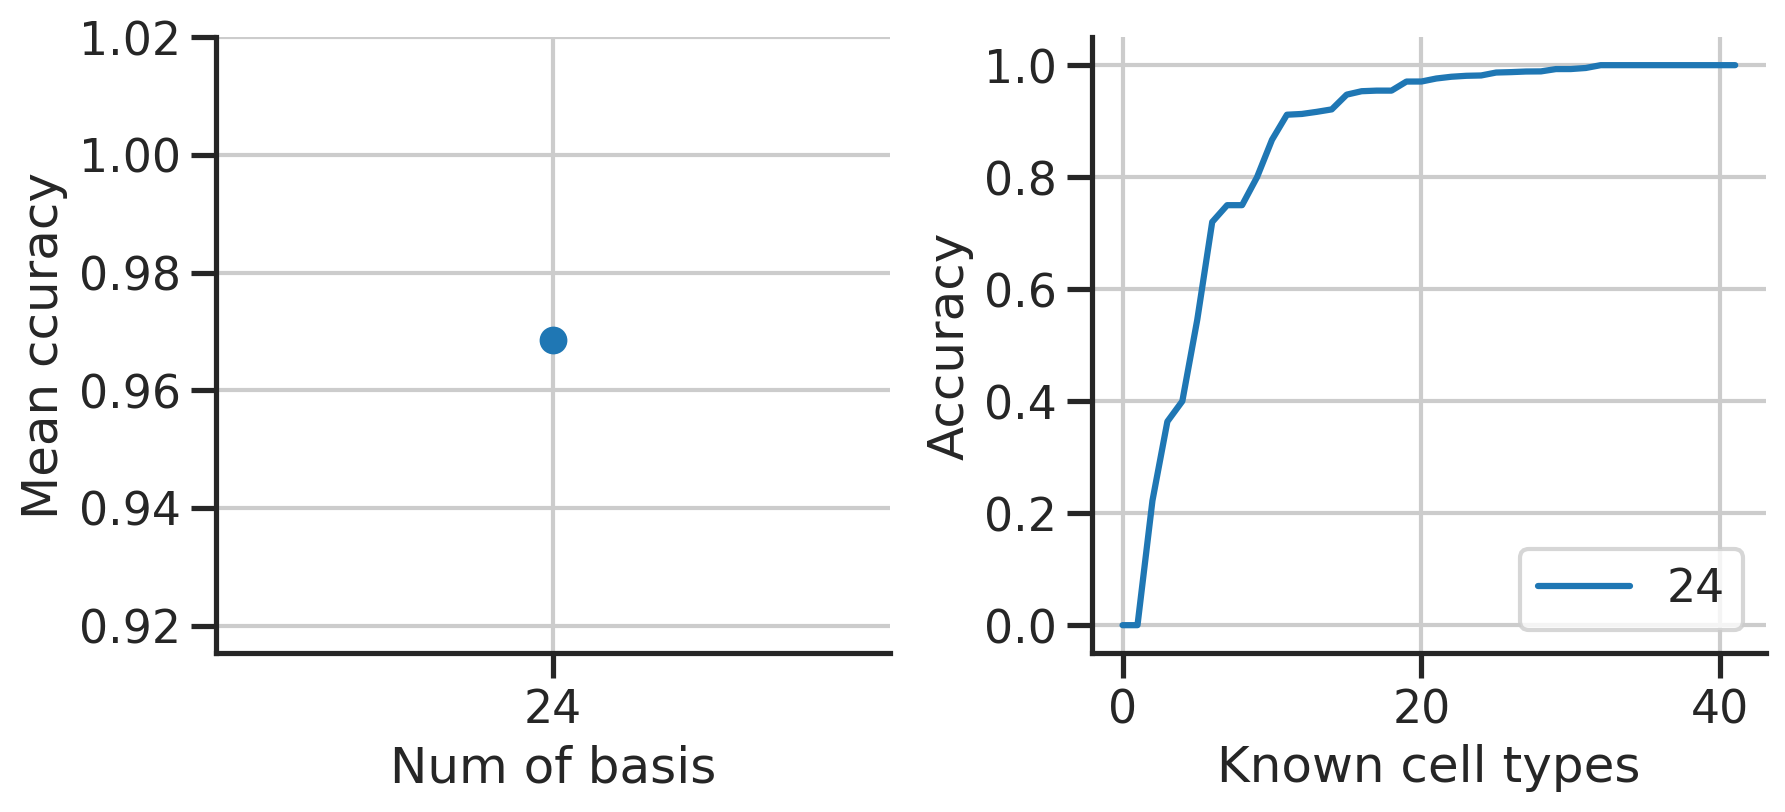

In [10]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
ax = axs[0]
ax.plot(nbits, n_bits_acc, '-o')
ax.set_ylim(ymax=1.02) #[0,1.02])
ax.set_xticks(nbits)
ax.set_xlabel('Num of basis')
ax.set_ylabel('Mean ccuracy')
sns.despine(ax=ax)

ax = axs[1]
for nbit, mean_acc in zip(nbits, mean_acc_all):
    ax.plot(np.sort(mean_acc), label=nbit)
ax.set_xlabel('Known cell types')
ax.set_ylabel('Accuracy')
ax.legend()
sns.despine(ax=ax)
fig.subplots_adjust(wspace=0.3)
plt.show()

### 3.2 check structures
- encoding
- projection
- embedding

In [11]:
encx = encx_all[0].numpy()
prjx = prjx_all[0].numpy()
embx = embx_all[0].numpy()
clsts = clsts_all[0].numpy()
encx.shape, prjx.shape, clsts.shape

((23282, 24), (5000, 24), (5000,))

In [12]:
pmat = pd.DataFrame(encx) #, index=genes)
nzero_prbe_cond = pmat.sum(axis=1) > 0
pospmat = pmat[nzero_prbe_cond]
fpmat = pospmat.divide(pospmat.sum(axis=0), axis=1)

prjx_clsts, _ = basicu.group_mean(prjx, clsts)
# prjx_clsts_z  = basicu.zscore(prjx_clsts, allow_nan=True, axis=0)
# prjx_clsts_corr = np.corrcoef(prjx_clsts_z)

embx_clsts, _ = basicu.group_mean(embx, clsts)
embx_clsts_z  = basicu.zscore(embx_clsts, allow_nan=True, axis=0)
embx_clsts_corr = np.corrcoef(embx_clsts_z)

# order by HC
_rows = order_by_hc(embx_clsts)
_cols = order_by_hc(embx_clsts.T)

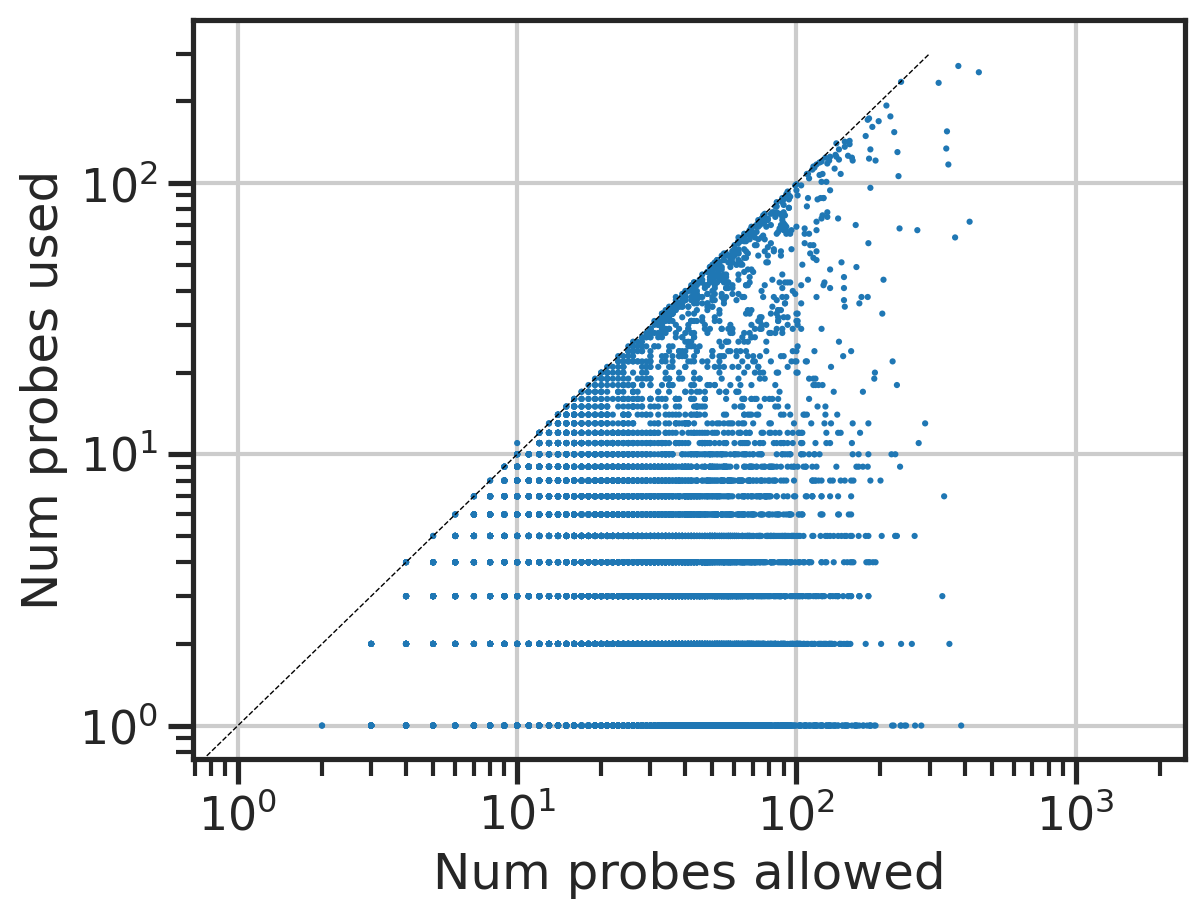

In [13]:
fig, ax = plt.subplots()
ax.scatter(cnstrnts, pmat.sum(axis=1), s=5, edgecolor='none')
ax.plot([0,300], [0,300], '--k', linewidth=0.5)
ax.set_xlabel('Num probes allowed')
ax.set_ylabel('Num probes used')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

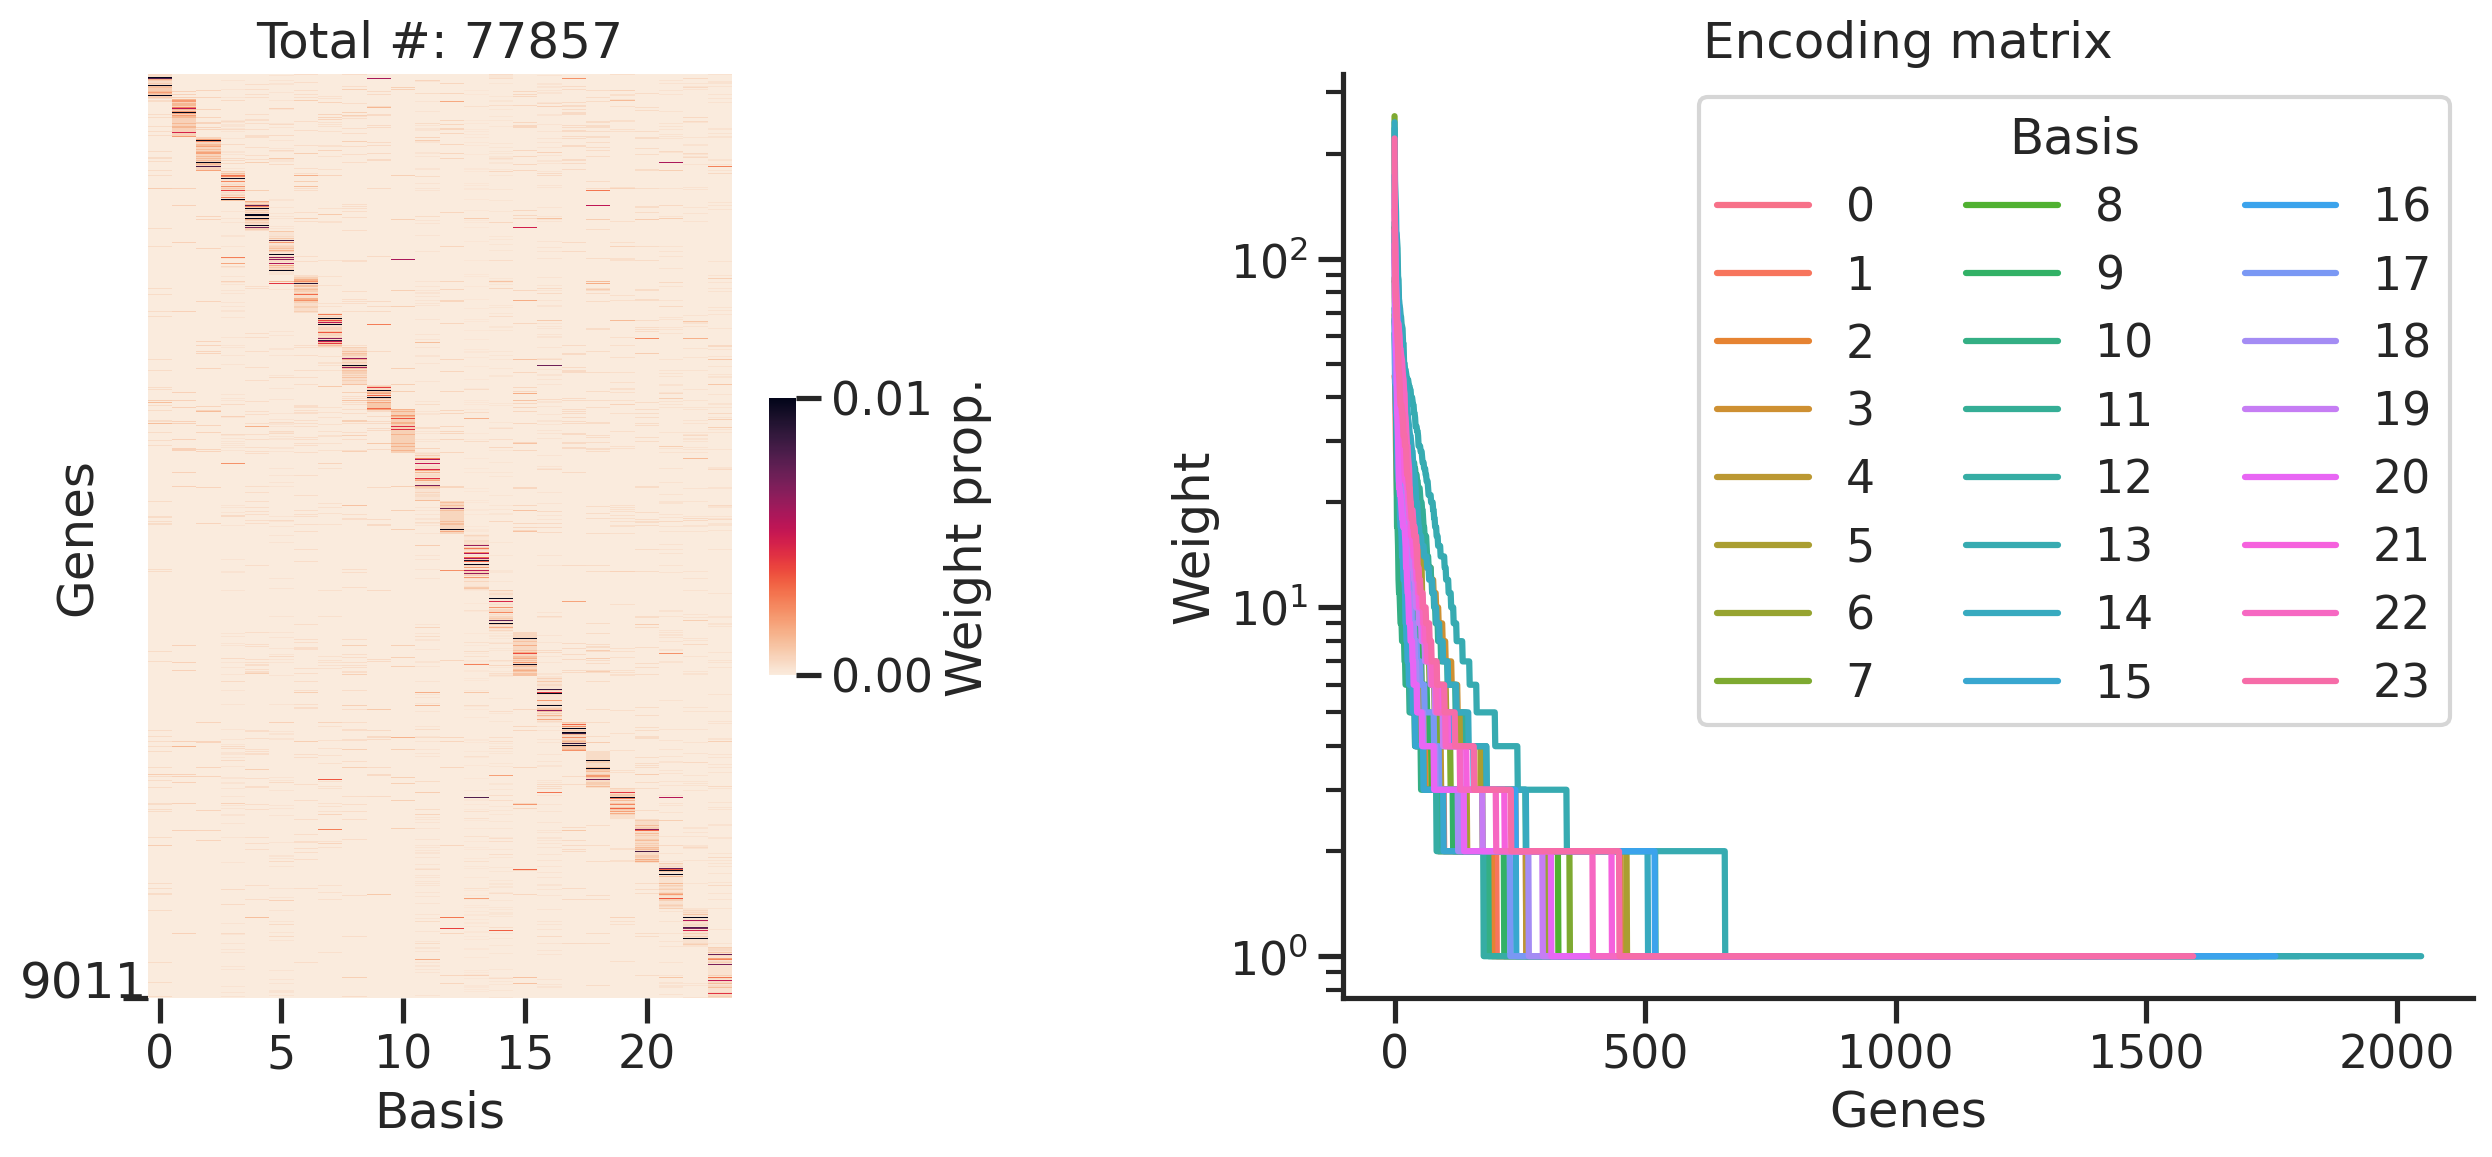

In [14]:
designu.plot_enc(pmat, fpmat)

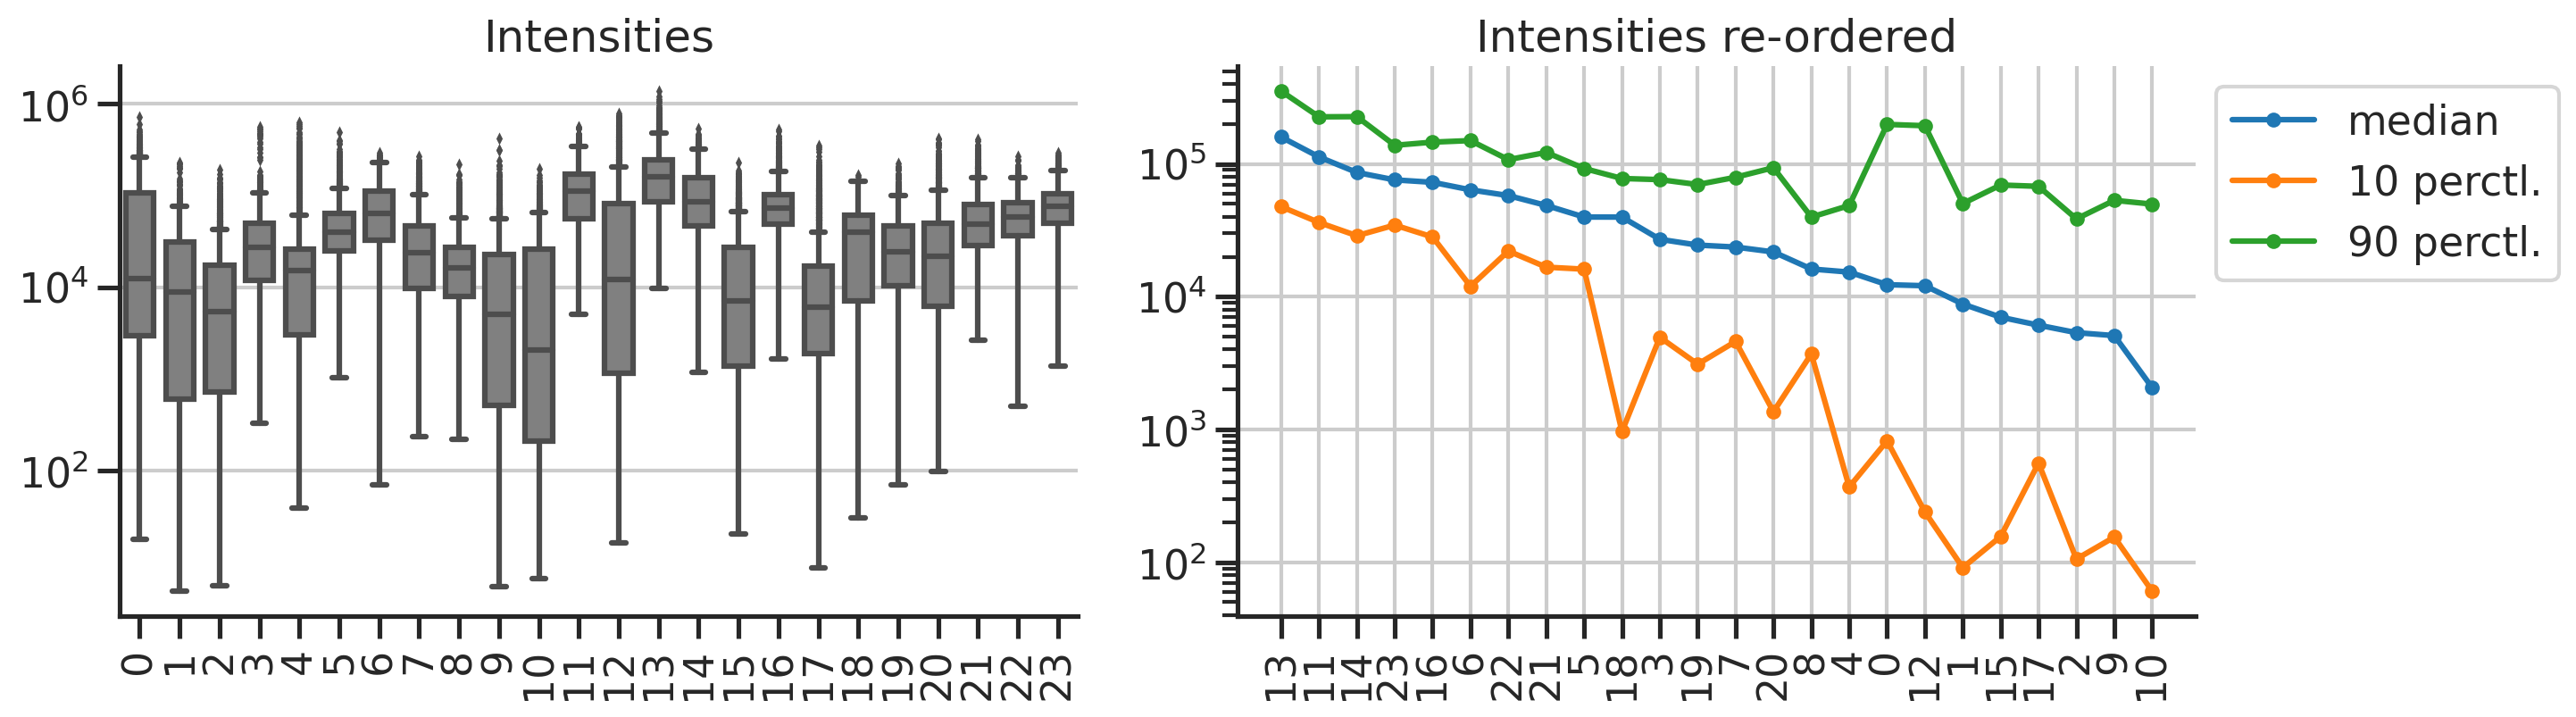

In [15]:
designu.plot_intn(prjx)

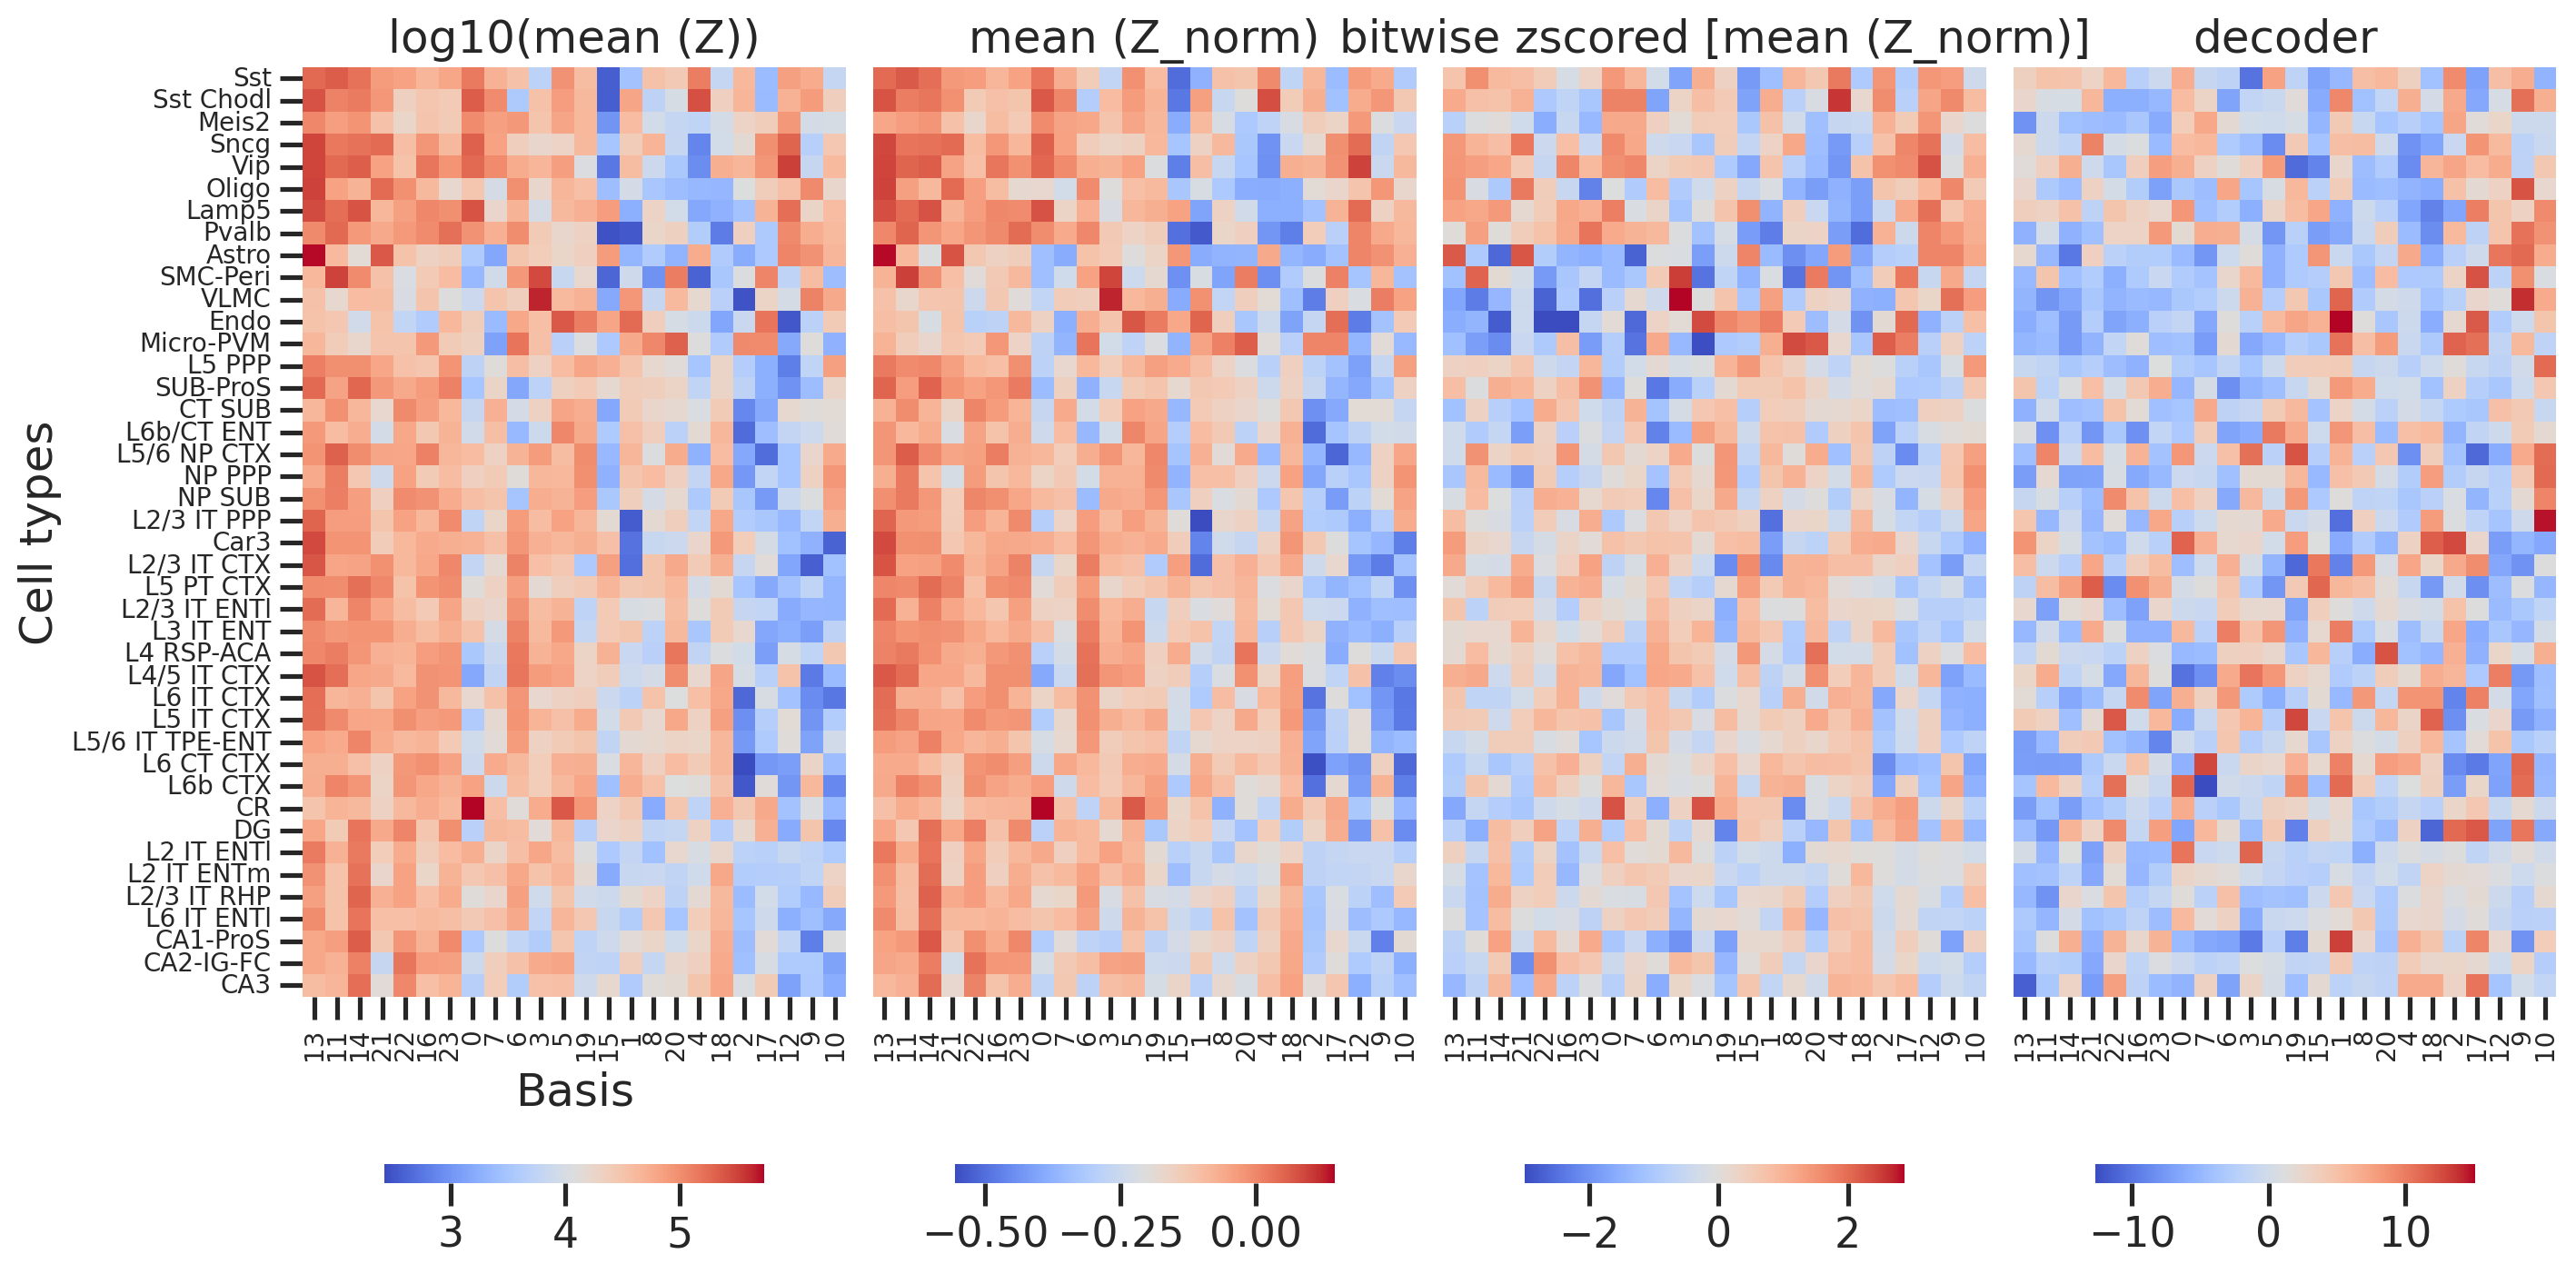

In [16]:
designu.plot_embx_clsts_v2(
    prjx_clsts, embx_clsts, embx_clsts_z, dcdx.T,
    rownames=type_orders, 
    _rows=_rows, _cols=_cols)

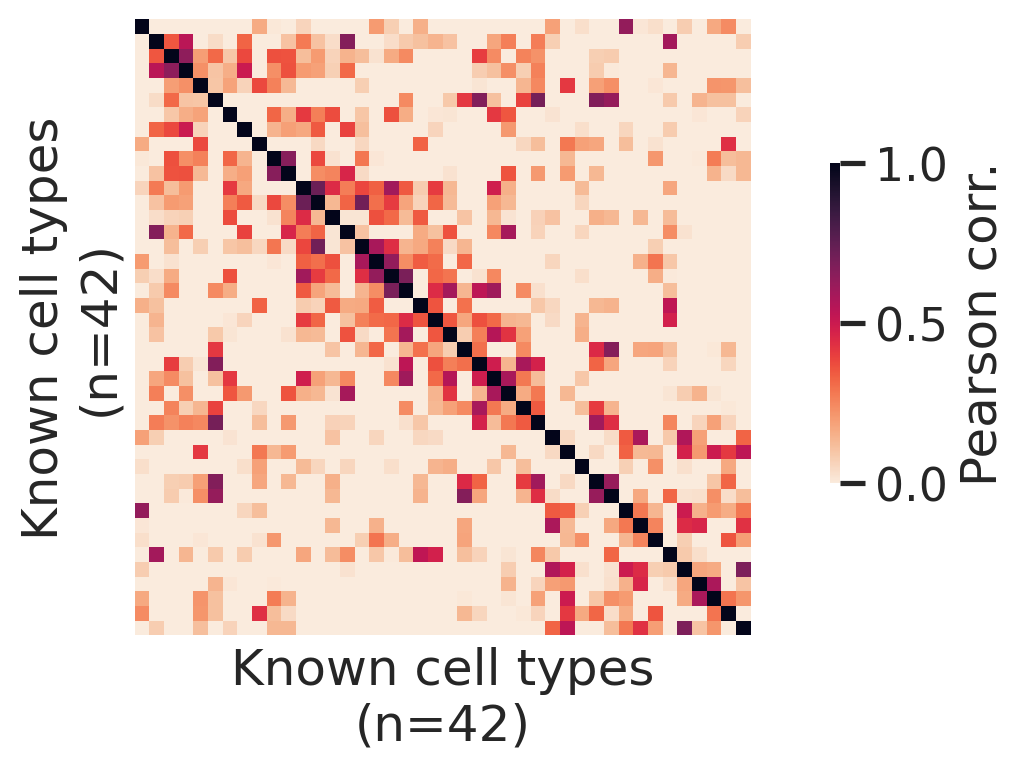

In [17]:
designu.plot_heatcorr(embx_clsts_corr, vmin=0)